In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

/home/aaiteam4/anaconda3/envs/resume-ai/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import nltk
from nltk.corpus import stopwords
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [3]:
import re
import string

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
# 1. Get the dataset from Hugging Face
dataset_name = "cnamuangtoun/resume-job-description-fit"
try:
    dataset = load_dataset(dataset_name)
    df = dataset['train'].to_pandas()
    print(f"Dataset '{dataset_name}' loaded successfully. Shape: {df.shape}")
    print("Column names in the DataFrame:")
    print(df.columns)
    # We need to identify the correct column names for text and labels
    TEXT_COLUMN = None  # We will update this based on the output
    LABEL_COLUMN = None # We will update this based on the output
except Exception as e:
    print(f"Error loading dataset '{dataset_name}': {e}")
    exit()

Dataset 'cnamuangtoun/resume-job-description-fit' loaded successfully. Shape: (6241, 3)
Column names in the DataFrame:
Index(['resume_text', 'job_description_text', 'label'], dtype='object')


In [7]:
# 2. Preprocessing
TEXT_COLUMN_RESUME = 'resume_text'
TEXT_COLUMN_JOB = 'job_description_text'
LABEL_COLUMN = 'label'

stop_words = set(stopwords.words('english'))
custom_stopwords = ['e.g.', 'i.e.', 'etc.', 'the', 'and', 'a', 'an', 'in', 'of', 'to'] # Add more if needed
stop_words.update(custom_stopwords)

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase
        text = text.lower()
        # Remove email addresses
        text = re.sub(r'\S*@\S*\s?', '', text)
        # Remove non-ASCII characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove numbers (keeping those with % $ or year format)
        text = re.sub(r'(?<!\d)(?<![\$\%])\b\d+\b', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove stopwords
        text_tokens = text.split()
        filtered_tokens = [w for w in text_tokens if not w in stop_words]
        return " ".join(filtered_tokens)
    return ""

print("Applying preprocessing...")
df['processed_resume'] = df[TEXT_COLUMN_RESUME].apply(preprocess_text)
df['processed_job_description'] = df[TEXT_COLUMN_JOB].apply(preprocess_text)
# Combine processed resume and job description for the model
df['combined_text'] = df['processed_resume'] + ' ' + df['processed_job_description']
df = df[df['combined_text'].str.len() > 0] # Remove rows with empty combined text
print("Preprocessing complete.")

Applying preprocessing...
Preprocessing complete.


In [8]:
# Combine all resume and job description texts to fit the vectorizer
all_texts = pd.concat([df['processed_resume'], df['processed_job_description']], axis=0)

# Initialize and fit the TF-IDF vectorizer on the combined corpus
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(all_texts)

# Split the data
X_resume_train, X_resume_test, X_job_train, X_job_test, y_train, y_test = train_test_split(
    df['processed_resume'], df['processed_job_description'], df[LABEL_COLUMN], test_size=0.2, random_state=42, stratify=df[LABEL_COLUMN]
)

# Transform the resume and job description texts using the fitted vectorizer
X_resume_train_tfidf = tfidf_vectorizer.transform(X_resume_train)
X_resume_test_tfidf = tfidf_vectorizer.transform(X_resume_test)
X_job_train_tfidf = tfidf_vectorizer.transform(X_job_train)
X_job_test_tfidf = tfidf_vectorizer.transform(X_job_test)

In [9]:
# Calculate Cosine Similarity
print("Calculating cosine similarity...")

def calculate_tfidf_similarity(resume_tfidf, job_tfidf):
    return cosine_similarity(resume_tfidf, job_tfidf)[0][0]

train_similarity = [
    calculate_tfidf_similarity(X_resume_train_tfidf[i], X_job_train_tfidf[i])
    for i in range(X_resume_train_tfidf.shape[0])
]

test_similarity = [
    calculate_tfidf_similarity(X_resume_test_tfidf[i], X_job_test_tfidf[i])
    for i in range(X_resume_test_tfidf.shape[0])
]

print("Cosine similarity calculated.")

Calculating cosine similarity...
Cosine similarity calculated.


In [10]:
# Prepare data for the model
X_train_tfidf_df = pd.DataFrame(X_resume_train_tfidf.toarray(), columns=[f'tfidf_resume_{i}' for i in range(X_resume_train_tfidf.shape[1])])
X_job_train_tfidf_df = pd.DataFrame(X_job_train_tfidf.toarray(), columns=[f'tfidf_job_{i}' for i in range(X_job_train_tfidf.shape[1])])
X_train_model = pd.concat([X_train_tfidf_df, X_job_train_tfidf_df], axis=1)
X_train_model['similarity'] = train_similarity
X_train_model.columns = X_train_model.columns.astype(str)  # Convert all column names to strings

X_test_tfidf_df = pd.DataFrame(X_resume_test_tfidf.toarray(), columns=[f'tfidf_resume_{i}' for i in range(X_resume_test_tfidf.shape[1])])
X_job_test_tfidf_df = pd.DataFrame(X_job_test_tfidf.toarray(), columns=[f'tfidf_job_{i}' for i in range(X_job_test_tfidf.shape[1])])
X_test_model = pd.concat([X_test_tfidf_df, X_job_test_tfidf_df], axis=1)
X_test_model['similarity'] = test_similarity
X_test_model.columns = X_test_model.columns.astype(str)    # Convert all column names to strings

In [11]:
# Initialize and train the models
gnb = GaussianNB()
gnb.fit(X_train_model, y_train)
gnb_predictions_combined = gnb.predict(X_test_model)


# Evaluate the model with combined features
print("\nGaussian Naive Bayes with TF-IDF and Cosine Similarity:")
print(classification_report(y_test, gnb_predictions_combined))
print("Accuracy:", accuracy_score(y_test, gnb_predictions_combined))


Gaussian Naive Bayes with TF-IDF and Cosine Similarity:
               precision    recall  f1-score   support

     Good Fit       0.52      0.85      0.65       309
       No Fit       0.77      0.27      0.40       629
Potential Fit       0.45      0.75      0.56       311

     accuracy                           0.53      1249
    macro avg       0.58      0.63      0.54      1249
 weighted avg       0.63      0.53      0.50      1249

Accuracy: 0.5348278622898318


In [12]:
cnb = ComplementNB()
cnb.fit(X_train_model, y_train)
cnb_predictions_combined = cnb.predict(X_test_model)

print("\nComplement Naive Bayes with TF-IDF and Cosine Similarity:")
print(classification_report(y_test, cnb_predictions_combined))
print("Accuracy:", accuracy_score(y_test, cnb_predictions_combined))


Complement Naive Bayes with TF-IDF and Cosine Similarity:
               precision    recall  f1-score   support

     Good Fit       0.74      0.26      0.39       309
       No Fit       0.56      0.94      0.70       629
Potential Fit       0.71      0.16      0.26       311

     accuracy                           0.58      1249
    macro avg       0.67      0.45      0.45      1249
 weighted avg       0.64      0.58      0.51      1249

Accuracy: 0.5796637309847879


In [13]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_model, y_train)
rf_predictions = rf.predict(X_test_model)

print("\nRandom Forest with TF-IDF and Cosine Similarity:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest with TF-IDF and Cosine Similarity:
               precision    recall  f1-score   support

     Good Fit       0.63      0.76      0.69       309
       No Fit       0.71      0.76      0.73       629
Potential Fit       0.69      0.44      0.54       311

     accuracy                           0.68      1249
    macro avg       0.67      0.65      0.65      1249
 weighted avg       0.68      0.68      0.67      1249

Accuracy: 0.6813450760608487


In [14]:
label_mapping = {'No Fit': 0, 'Potential Fit': 1, 'Good Fit': 2}
y_train_encoded = y_train.map(label_mapping)

y_test_encoded = y_test.map(label_mapping)

In [15]:
# Initialize and train the XGBoost model with combined features
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_model, y_train_encoded)  # Use the numerically encoded y_train
xgb_predictions = xgb_model.predict(X_test_model)

# Evaluate the model with combined features
print("\nXGBoost with TF-IDF Features and Cosine Similarity:")
print(classification_report(y_test_encoded, xgb_predictions))
print("Accuracy:", accuracy_score(y_test_encoded, xgb_predictions))


XGBoost with TF-IDF Features and Cosine Similarity:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       629
           1       0.71      0.57      0.63       311
           2       0.68      0.83      0.75       309

    accuracy                           0.74      1249
   macro avg       0.73      0.73      0.72      1249
weighted avg       0.74      0.74      0.74      1249

Accuracy: 0.7397918334667735


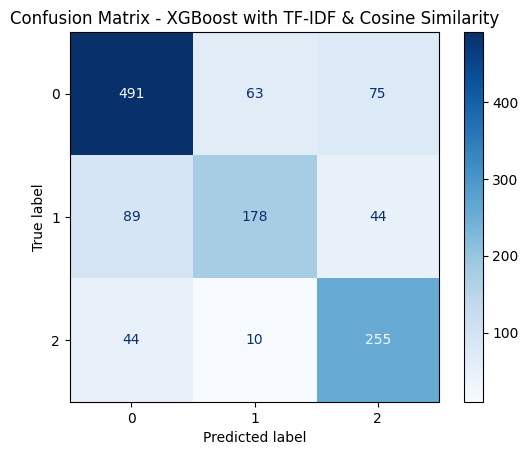

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test_encoded, xgb_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost with TF-IDF & Cosine Similarity")
plt.show()

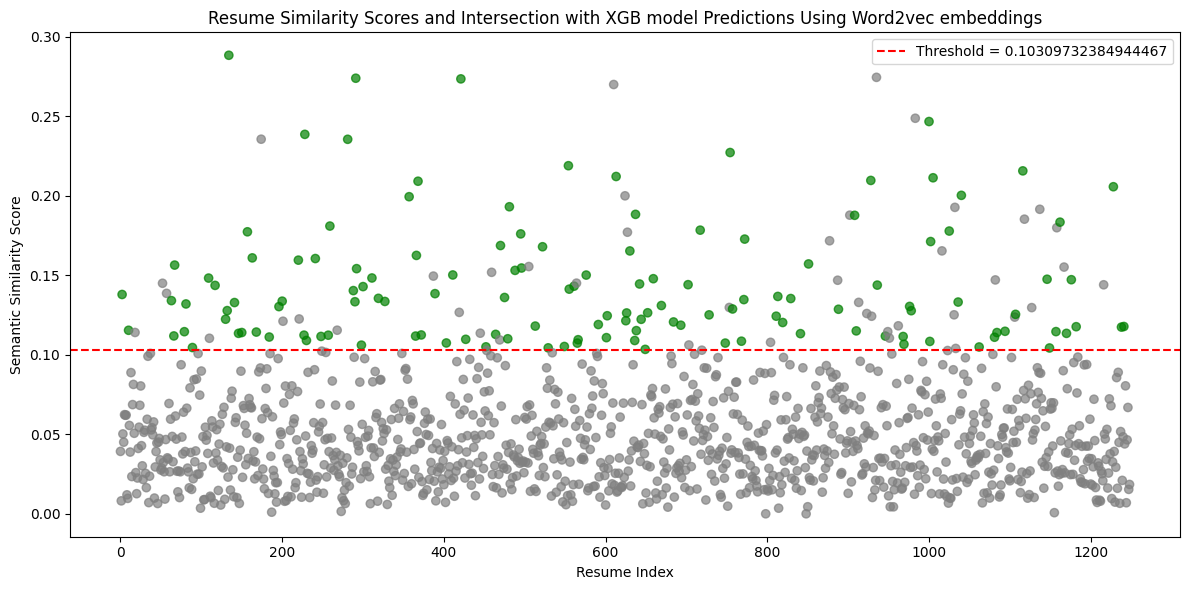

In [20]:
import numpy as np
def compute_similarity_scores(resume_embed, jd_embed):
    similarities = cosine_similarity(resume_embed.reshape(1, -1), jd_embed.reshape(1, -1))
    return similarities[0, 0]  # each resume vs its own JD



similarity_scores = [
    compute_similarity_scores(X_resume_test_tfidf[i], X_job_test_tfidf[i])
    for i in range(X_resume_test.shape[0])
]

mean_similarity = np.mean(similarity_scores)
std_dev_similarity = np.std(similarity_scores)
threshold = mean_similarity + 1 * std_dev_similarity

#xgb_labels = xgb_predictions.map(inverse_label_mapping)
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
xgb_labels = [inverse_label_mapping[pred] for pred in xgb_predictions]


intersection_indices = [
    i for i, (label, score) in enumerate(zip(xgb_labels, similarity_scores))
    if (label == 'Good Fit' or label == 'Potential Fit') and score >= threshold
]

# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(similarity_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(similarity_scores)), similarity_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with XGB model Predictions Using Word2vec embeddings')
plt.legend()
plt.tight_layout()
plt.show()